## Loess function

In [14]:
import numpy as np
import time
import math


def tricubic(x):
    y = np.zeros_like(x)
    idx = (x >= -1) & (x <= 1)
    y[idx] = np.power(1.0 - np.power(np.abs(x[idx]), 3), 3)
    return y


class Loess(object):

    @staticmethod
    def normalize_array(array):
        min_val = np.min(array)
        max_val = np.max(array)
        return (array - min_val) / (max_val - min_val), min_val, max_val

    def __init__(self, xx, yy, degree=1):
        self.n_xx, self.min_xx, self.max_xx = self.normalize_array(xx)
        self.n_yy, self.min_yy, self.max_yy = self.normalize_array(yy)
        self.degree = degree

    @staticmethod
    def get_min_range(distances, window):
        min_idx = np.argmin(distances)
        n = len(distances)
        if min_idx == 0:
            return np.arange(0, window)
        if min_idx == n-1:
            return np.arange(n - window, n)

        min_range = [min_idx]
        while len(min_range) < window:
            i0 = min_range[0]
            i1 = min_range[-1]
            if i0 == 0:
                min_range.append(i1 + 1)
            elif i1 == n-1:
                min_range.insert(0, i0 - 1)
            elif distances[i0-1] < distances[i1+1]:
                min_range.insert(0, i0 - 1)
            else:
                min_range.append(i1 + 1)
        return np.array(min_range)

    @staticmethod
    def get_weights(distances, min_range):
        max_distance = np.max(distances[min_range])
        weights = tricubic(distances[min_range] / max_distance)
        return weights

    def normalize_x(self, value):
        return (value - self.min_xx) / (self.max_xx - self.min_xx)

    def denormalize_y(self, value):
        return value * (self.max_yy - self.min_yy) + self.min_yy

    def estimate(self, x, window, use_matrix=False, degree=1):
        n_x = self.normalize_x(x)
        distances = np.abs(self.n_xx - n_x)
        min_range = self.get_min_range(distances, window)
        weights = self.get_weights(distances, min_range)

        if use_matrix or degree > 1:
            wm = np.multiply(np.eye(window), weights)
            xm = np.ones((window, degree + 1))

            xp = np.array([[math.pow(n_x, p)] for p in range(degree + 1)])
            for i in range(1, degree + 1):
                xm[:, i] = np.power(self.n_xx[min_range], i)

            ym = self.n_yy[min_range]
            xmt_wm = np.transpose(xm) @ wm
            beta = np.linalg.pinv(xmt_wm @ xm) @ xmt_wm @ ym
            y = (beta @ xp)[0]
        else:
            xx = self.n_xx[min_range]
            yy = self.n_yy[min_range]
            sum_weight = np.sum(weights)
            sum_weight_x = np.dot(xx, weights)
            sum_weight_y = np.dot(yy, weights)
            sum_weight_x2 = np.dot(np.multiply(xx, xx), weights)
            sum_weight_xy = np.dot(np.multiply(xx, yy), weights)

            mean_x = sum_weight_x / sum_weight
            mean_y = sum_weight_y / sum_weight

            b = (sum_weight_xy - mean_x * mean_y * sum_weight) / \
                (sum_weight_x2 - mean_x * mean_x * sum_weight)
            a = mean_y - b * mean_x
            y = a + b * n_x
        return self.denormalize_y(y)

## Loading up packages

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
from Bio import SeqIO
import numpy
import Loess as lo
import pandas as pd
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

In [3]:
# Define the path to our Bam files
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/ecol/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/ecol/'

In [4]:
# Create a function that finds the proteins I need. 
def find_transcripts(gene,transcripts, count_vec_m, count_vec_c):
    '''
    A function that takes the name of a gene as input and finds 
    the corresponding transcript from a transcript list. 
    
    returns both the transcript in question and the vector of counts for that transcript.
    
    This function is still a work in progress as for now it simply gives the last 
    transcript in the list that matches the gene ID. 
    '''
    for i in transcripts:
        if i.attr['transcript_biotype'] == 'protein_coding':
            if i.attr['gene_name'] == gene:
                my_transcript = i
                index = transcripts.index(i)
                my_vector_m = count_vec_m[transcripts.index(i)]
                my_vector_c = count_vec_c[transcripts.index(i)]
                
    return my_transcript, my_vector_m, my_vector_c, index

## Loading up the data files 

In [5]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + "Escherichia_coli_str_k_12_substr_mg1655_gca_000005845.ASM584v2.51.gtf"),return_type=Transcript))

In [6]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['gene_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [7]:
# clear up some memory by deleting original transcript list
transcripts.clear()

# Loading up the csv file.

In [8]:
def load_count_positions(csv_name, csv_path):
    data = []
    with open(csv_path + csv_name, newline = '') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data.append(row)
    blank=data.pop(0)
            
    for i,ii in zip(data, range(len(data))):
        for j,jj in zip(i, range(len(i))):
            try:
                x = int(float(j))
                data[ii][jj] = x
            except:
                pass
            
    # Remove empty space
    for i,ii in zip(data, range(len(data))):
        x = list(filter(('').__ne__, i))
        data[ii] = x
        
    # Convert lists to np.arrays
    for i,ii in zip(data, range(len(data))):
        data[ii] = np.array(data[ii][2:])
    
    return data

In [9]:
data_mutant = load_count_positions("efp_1_counts.csv",csv_path)
data_control = load_count_positions("control_RPF_1_counts.csv",csv_path)

## Choose the gene of interest and smooth out the array.

hmmmm, flk is a weird one, need to look out for it.

In [68]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_transcript, my_vec_mutant, my_vec_control, index = find_transcripts("cysQ", 
                                           protein_coding, data_mutant, data_control)

In [69]:
# Create a vector that just reflects the positions along the transcript
my_position = np.array(list(range(len(my_vec_mutant))))

In [70]:
# define a function that calculates the smoothed vector using loess and calculates the cumulative sum of said vector.
def get_smoothed_vector(positions, vector, frac = 0.05):
    loess = Loess(positions, vector/sum(vector))
    smoothed_vec = []
    for x in positions:
        y = loess.estimate(x, window=int(len(positions)*frac), use_matrix=False, degree=1)
        smoothed_vec.append(y)
    smoothed_vec = np.array(smoothed_vec)
    cumsum = np.cumsum(smoothed_vec)
    return smoothed_vec, cumsum

In [71]:
smoothed_vec_m, cumul_m = get_smoothed_vector(my_position, my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = get_smoothed_vector(my_position, my_vec_control+0.00000000001)

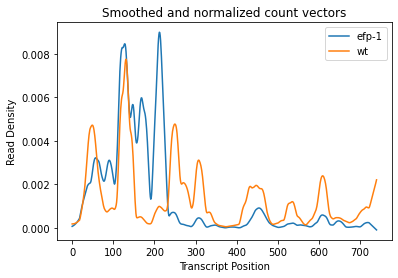

In [72]:
plt.plot(smoothed_vec_m, label = "efp-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "wt")
plt.ylabel("Read Density")
plt.xlabel("Transcript Position")
plt.title("Smoothed and normalized count vectors")
plt.legend()

## Plot and calculate the correlation of the cumulative sum * The transcript position

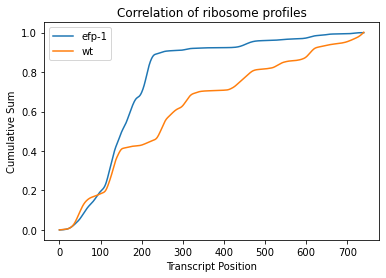

In [73]:
plt.plot(my_position, cumul_m, label = "efp-1")
plt.plot(my_position, cumul_c, label = "wt")
plt.ylabel("Cumulative Sum")
plt.xlabel("Transcript Position")
plt.title("Correlation of ribosome profiles")
plt.legend()

In [74]:
stats.ks_2samp(cumul_m, cumul_c)

KstestResult(statistic=0.5060728744939271, pvalue=1.0197829084648163e-86)

## Determine correlation for all transcripts

In [23]:
stats.norm()

In [26]:
x = np.linspace(-15, 15, 9)
stats.kstest(x, 'norm')

KstestResult(statistic=0.4443560271592436, pvalue=0.03885014008678778)

In [56]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
ks_list = []
for tr_m, tr_c, index in zip(data_mutant, data_control, list(range(len(data_mutant)))):
    if len(tr_m) > 200 and sum(tr_m) > 100 and sum(tr_c) > 100:
        position = np.array(list(range(len(tr_m))))
        smoothed_vec_m, cumul_m = get_smoothed_vector(position, tr_m+0.00000000001)
        smoothed_vec_c, cumul_c = get_smoothed_vector(position, tr_c+0.00000000001)
        ks = stats.ks_2samp(cumul_m, cumul_c)[0]
        #if ks < 0.85 :
        #    print(protein_coding[index].attr["gene_name"])
        ks_list.append(ks)

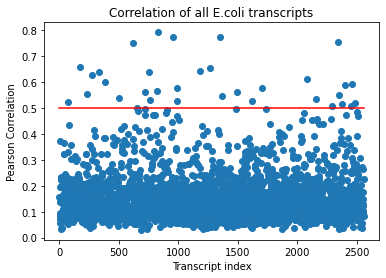

In [66]:
plt.scatter(list(range(len(ks_list))), ks_list)
plt.ylabel("Pearson Correlation")
plt.xlabel("Transcript index")
plt.title("Correlation of all E.coli transcripts")
plt.plot([0,len(ks_list)],[0.5,0.5], "r")

In [30]:
rng = np.random.default_rng()
n1 = 200  # size of first sample
n2 = 300  # size of second sample
rvs1 = stats.norm.rvs(size=n1, loc=0., scale=1, random_state=rng)
rvs2 = stats.norm.rvs(size=n2, loc=0.5, scale=1.5, random_state=rng)
stats.ks_2samp(rvs1, rvs2)

KstestResult(statistic=0.27166666666666667, pvalue=2.9503204435066266e-08)

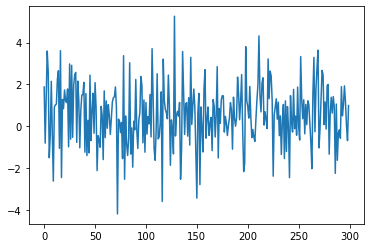

In [35]:
plt.plot(rvs2)